# VAriational Autoencoder on Fashion MNIST

**Imports and setting up the manual seed:**

In [ ]:
import random
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.distributions import Normal
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
from torchvision.utils import make_grid
from torchvision import datasets, transforms
import torchvision.datasets as dset
import torchvision.transforms as transforms
from tqdm import tqdm
from torchvision.utils import save_image
import torchvision.utils as vutils
import numpy as np


# Set random seed for reproducibility
manualSeed = 543
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  543


In [ ]:
workers = 2 # Number of workers for dataloader
batch_size = 128
image_size = 28
image_flat_size = 784
latent_space_size = 100

num_epochs = 15
lr = 1e-3
#ngpu = 1 # Number of GPUs available. Use 0 for CPU mode.

**Loading the dataset:**

In [ ]:
#directory for dataset
dataroot = '~/.pytorch/F_MNIST_data'
# Create the dataset
dataset = datasets.FashionMNIST(root=dataroot,
                           download=True, train=True, 
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
#device = torch.device("cuda:0" if (torch.cuda.is_available() ) else "cpu")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Found device : {device}")


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw

Found device : cpu


In [ ]:
real_batch = next(iter(dataloader))
np.shape(real_batch[0].to(device)[0])

torch.Size([1, 28, 28])

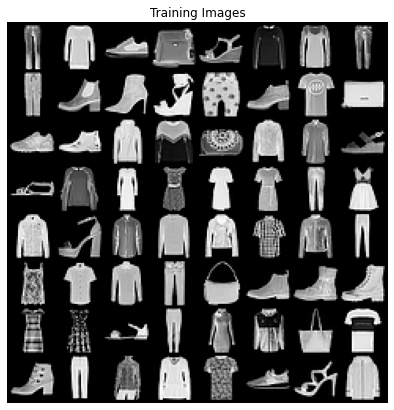

In [ ]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(7,7))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

**Defining models:**

In [ ]:
# Encoder and Decoder classes

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(image_flat_size, 1000),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Linear(500, 250),
            nn.ReLU()
        )
        self.mu = nn.Linear(250, 2)
        self.std = nn.Linear(250, 2)

        
    def forward(self, x):
        x = x.view(-1, 1, image_flat_size)
        x = self.main(x)
        mu = self.mu(x)
        std = self.std(x)
        return mu, std


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(2, 250),
            nn.ReLU(),
            nn.Linear(250, 500),
            nn.ReLU(),
            nn.Linear(500, 1000),
            nn.ReLU(),
            nn.Linear(1000, image_flat_size),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.main(x)
        x = x.view(-1, 1, image_size, image_size)
        return x
    

**Reparameterization, Gassian form & KL-Divergence functions:**

In [ ]:
def reparameterization(mu, std):
    # Reparamaterization trick: 
    # instead of x ~ N(mu, std), we do: x = mu + std * N(0,1) 
    # to compute gradients w.r.t mu & std
    log_std = torch.exp(0.5*std)
    eps = torch.randn_like(mu)
    samples = mu + (eps * log_std)
    return samples

In [ ]:
class Gaussian:
    def __init__(self, mu, std):
        self.mu = mu
        self.std = std
    
    def RVs(self, n_samples=1):
        #normal_dist = torch.distributions.MultivariateNormal(loc=self.mean, covariance_matrix=torch.randn_like(self.mu))
        return self.std * torch.randn_like(self.mu) + self.mu
        
    def log_PDF(self, x):
        a = torch.log(self.std ** 2)
        b = ((x - self.mu)/self.std) ** 2
        return -0.5 * torch.sum(a+b, dim=-1)

def KL(q, p): #Kullback-Leibler , KL-Divergence
    q_samples = q.RVs()
    return torch.mean(q.log_PDF(q_samples) - p.log_PDF(q_samples))

In [ ]:
# mu = torch.Tensor([2, 2])
# scale1 = torch.Tensor([1, 1])
# cov1 = torch.diag_embed(scale1)
# diag_normal_mv1 = torch.distributions.MultivariateNormal(loc=mu, covariance_matrix=cov1)
# print(diag_normal_mv1.loc)

In [ ]:
# Create encoder & decoder
encoder = Encoder()
decoder = Decoder()

encoder = encoder.to(device)
decoder = decoder.to(device)

# Print the model
print(encoder)
print(decoder)

Encoder(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=250, bias=True)
    (5): ReLU()
  )
  (mu): Linear(in_features=250, out_features=2, bias=True)
  (std): Linear(in_features=250, out_features=2, bias=True)
)
Decoder(
  (main): Sequential(
    (0): Linear(in_features=2, out_features=250, bias=True)
    (1): ReLU()
    (2): Linear(in_features=250, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=1000, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1000, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


**Optimizer & Loss:**

In [ ]:
# Sum of both params to be passed to the optimizer!
params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(params=params, lr=lr, betas=(0.9, 0.999))
criterion = nn.BCELoss(reduction='sum')

**Training the VAE...**

In [ ]:
encoder.train()
decoder.train()

KL_loss, RECONST_loss, ELBO_loss = [], [], []

for epoch in range(num_epochs):
    kl_batch_loss, reconst_batch_loss, elbo_batch_loss  = [],[],[]

    for data, label in tqdm(dataloader):

        data = data.to(device)
        optimizer.zero_grad()

        # reparametrization
        z_means, z_stds = encoder(data)
        z = reparameterization(z_means, z_stds)

        # decoding/generation
        x = decoder(z)

        #Gaussian forms
        pz = Gaussian(mu=torch.zeros_like(z), std=torch.ones_like(z))
        z_stds_log = torch.exp(z_stds)
        qzx = Gaussian(mu=z_means, std=z_stds_log)
        
        # loss and divergence calculation
        loss_reconstruction = criterion(x, data)/batch_size
        loss_kl = torch.mean(KL(qzx, pz))

        #loss_kl = -torch.mean(0.5*torch.sum(1 - torch.pow(z_stds,2) - torch.pow(z_means,2) + torch.log(torch.pow(z_stds,2)), dim=-1))
        loss = loss_reconstruction + loss_kl

        loss.backward()
        optimizer.step()
        
        kl_batch_loss.append(loss_kl.item())
        reconst_batch_loss.append(loss_reconstruction.item())
        elbo_batch_loss.append(loss.item())
        
    KL_loss.append(np.mean(kl_batch_loss))
    RECONST_loss.append(np.mean(reconst_batch_loss))
    ELBO_loss.append(np.mean(elbo_batch_loss))
    print()
    print(f"Epoch {epoch}: Reconstruction_Loss:{RECONST_loss[-1]}, KL_loss:{KL_loss[-1]}, Evidence Lower Bound:{ELBO_loss[-1]}")
    print()

100%|██████████| 469/469 [00:14<00:00, 33.33it/s]



Epoch 0: Reconstruction_Loss:-37130.83583338886, KL_loss:19.450734797317082, Evidence Lower Bound:-37111.38505713619



100%|██████████| 469/469 [00:14<00:00, 32.25it/s]



Epoch 1: Reconstruction_Loss:-39284.22962753198, KL_loss:16.214533777379277, Evidence Lower Bound:-39268.015087786516



100%|██████████| 469/469 [00:14<00:00, 31.89it/s]



Epoch 2: Reconstruction_Loss:-39450.78438582756, KL_loss:15.432992345488657, Evidence Lower Bound:-39435.35143340218



100%|██████████| 469/469 [00:15<00:00, 31.13it/s]



Epoch 3: Reconstruction_Loss:-39618.806977945096, KL_loss:15.705927944386692, Evidence Lower Bound:-39603.101079424305



100%|██████████| 469/469 [00:16<00:00, 27.83it/s]



Epoch 4: Reconstruction_Loss:-39086.59533248934, KL_loss:15.828658490292808, Evidence Lower Bound:-39070.766657782515



100%|██████████| 469/469 [00:16<00:00, 28.37it/s]



Epoch 5: Reconstruction_Loss:-37885.980893523454, KL_loss:15.843251956297136, Evidence Lower Bound:-37870.13749750133



100%|██████████| 469/469 [00:15<00:00, 29.76it/s]



Epoch 6: Reconstruction_Loss:-37384.84292543976, KL_loss:15.98935808250899, Evidence Lower Bound:-37368.853461487204



100%|██████████| 469/469 [00:15<00:00, 30.20it/s]



Epoch 7: Reconstruction_Loss:-37549.83901086087, KL_loss:16.000452667919557, Evidence Lower Bound:-37533.83861523854



100%|██████████| 469/469 [00:15<00:00, 30.90it/s]



Epoch 8: Reconstruction_Loss:-38234.18986540512, KL_loss:16.273094710002322, Evidence Lower Bound:-38217.9166819363



100%|██████████| 469/469 [00:15<00:00, 30.84it/s]



Epoch 9: Reconstruction_Loss:-38817.52484924707, KL_loss:72343940.32198894, Evidence Lower Bound:72305120.85985391



100%|██████████| 469/469 [00:15<00:00, 29.51it/s]



Epoch 10: Reconstruction_Loss:-39012.064877898454, KL_loss:17.23717445300332, Evidence Lower Bound:-38994.8277501999



100%|██████████| 469/469 [00:15<00:00, 29.43it/s]



Epoch 11: Reconstruction_Loss:-39131.65857376066, KL_loss:17.066774234080366, Evidence Lower Bound:-39114.59176772388



100%|██████████| 469/469 [00:15<00:00, 29.93it/s]



Epoch 12: Reconstruction_Loss:-39051.97657082889, KL_loss:17.025111155723458, Evidence Lower Bound:-39034.951492537315



100%|██████████| 469/469 [00:15<00:00, 31.22it/s]



Epoch 13: Reconstruction_Loss:-38940.36570495736, KL_loss:17.04105889212602, Evidence Lower Bound:-38923.32453524787



100%|██████████| 469/469 [00:15<00:00, 31.12it/s]


Epoch 14: Reconstruction_Loss:-38948.812016924305, KL_loss:17.303954943919234, Evidence Lower Bound:-38931.50797491338



# Generate new samples with variational autoencoder:

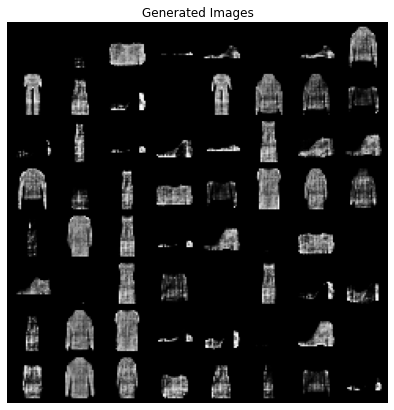

In [ ]:
new_z = torch.randn_like(z_means)
new_x = decoder(new_z)
plt.figure(figsize=(7,7))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(new_x.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))